In [ ]:
! pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d simranvolunesia/pest-dataset

 96% 67.0M/69.5M [00:01<00:00, 57.7MB/s]
100% 69.5M/69.5M [00:01<00:00, 52.3MB/s]


In [ ]:
!unzip pest-dataset

Archive:  pest-dataset.zip
  inflating: pest/test/aphids/jpg_0 - Copy.jpg  
  inflating: pest/test/aphids/jpg_0.jpg  
  inflating: pest/test/aphids/jpg_11 - Copy.jpg  
  inflating: pest/test/aphids/jpg_11.jpg  
  inflating: pest/test/aphids/jpg_13 - Copy.jpg  
  inflating: pest/test/aphids/jpg_13.jpg  
  inflating: pest/test/aphids/jpg_15 - Copy.jpg  
  inflating: pest/test/aphids/jpg_15.jpg  
  inflating: pest/test/aphids/jpg_16.jpg  
  inflating: pest/test/aphids/jpg_19.jpg  
  inflating: pest/test/aphids/jpg_2 - Copy.jpg  
  inflating: pest/test/aphids/jpg_2.jpg  
  inflating: pest/test/aphids/jpg_23.jpg  
  inflating: pest/test/aphids/jpg_24.jpg  
  inflating: pest/test/aphids/jpg_25.jpg  
  inflating: pest/test/aphids/jpg_27.jpg  
  inflating: pest/test/aphids/jpg_29.jpg  
  inflating: pest/test/aphids/jpg_30.jpg  
  inflating: pest/test/aphids/jpg_32.jpg  
  inflating: pest/test/aphids/jpg_33.jpg  
  inflating: pest/test/aphids/jpg_35.jpg  
  inflating: pest/test/aphids/jpg_36.jp

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, datasets, models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random
import pathlib

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_ds = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_ds = ImageDataGenerator(rescale=1./255)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory('/content/pest/train',
  validation_split=0.8,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2700 files belonging to 9 classes.
Using 540 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory('/content/pest/test',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 450 files belonging to 9 classes.
Using 90 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['aphids', 'armyworm', 'beetle', 'bollworm', 'grasshopper', 'mites', 'mosquito', 'sawfly', 'stem_borer']


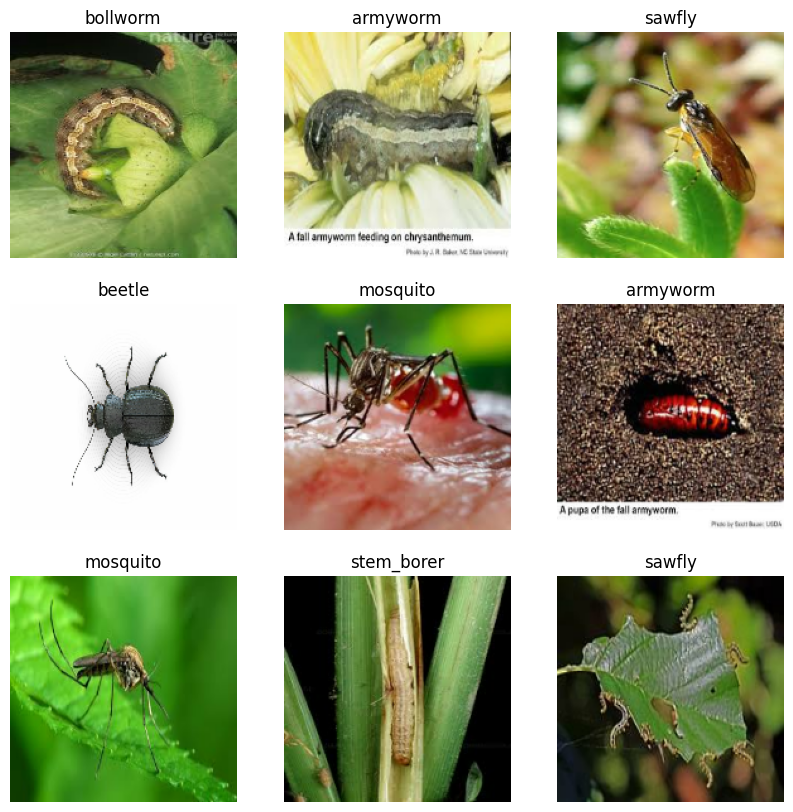

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.9073647


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
17/17 [==============================] - 20s 1s/step - loss: 2.3300 - accuracy: 0.1352 - val_loss: 2.1811 - val_accuracy: 0.1444
Epoch 2/10
17/17 [==============================] - 19s 1s/step - loss: 2.0343 - accuracy: 0.2889 - val_loss: 1.9202 - val_accuracy: 0.3556
Epoch 3/10
17/17 [==============================] - 18s 1s/step - loss: 1.6414 - accuracy: 0.4463 - val_loss: 1.8051 - val_accuracy: 0.2889
Epoch 4/10
17/17 [==============================] - 18s 1s/step - loss: 1.2621 - accuracy: 0.5944 - val_loss: 1.5003 - val_accuracy: 0.4222
Epoch 5/10
17/17 [==============================] - 17s 1s/step - loss: 0.7967 - accuracy: 0.7611 - val_loss: 1.3119 - val_accuracy: 0.6778
Epoch 6/10
17/17 [==============================] - 20s 1s/step - loss: 0.4796 - accuracy: 0.8759 - val_loss: 1.1545 - val_accuracy: 0.6889
Epoch 7/10
17/17 [==============================] - 18s 1s/step - loss: 0.3079 - accuracy: 0.9241 - val_loss: 1.1234 - val_accuracy: 0.7000
Epoch 8/10
17/17 [==

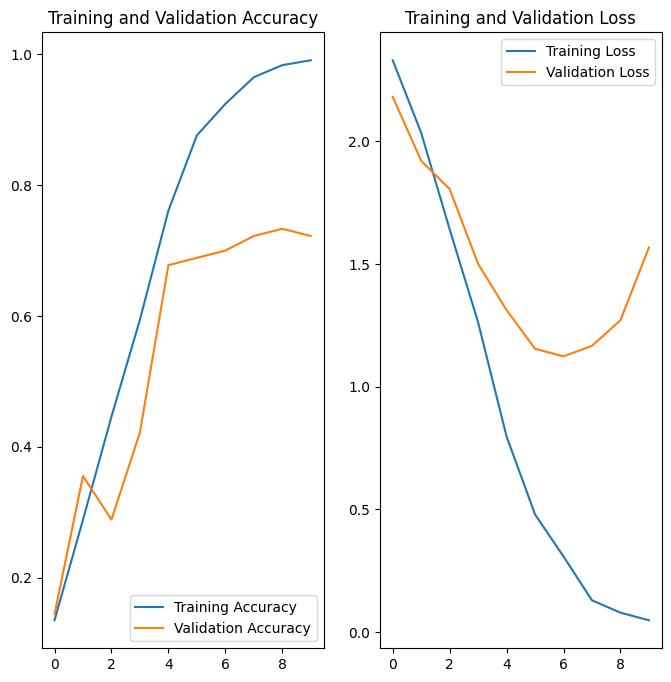

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

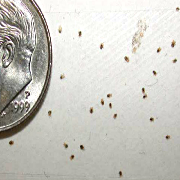

In [ ]:

from tensorflow.keras.preprocessing import image

img = image.load_img('/content/pest/test/mites/jpg_14.jpg',target_size=(img_height,img_width))
img

In [ ]:
test_image=image.img_to_array(img)
test_image=np.expand_dims(test_image, axis = 0)

result =np.argmax(model.predict(test_image), axis=1)
result

1/1 [==============================] - 0s 137ms/step


array([5])

In [ ]:
prediction = class_names[result[0]]
prediction

'mites'

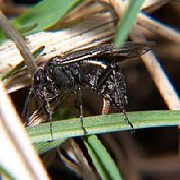

In [ ]:
img = image.load_img('/content/pest/test/sawfly/jpg_10.jpg',target_size=(img_height,img_width))
img

In [ ]:
test_image=image.img_to_array(img)
test_image=np.expand_dims(test_image, axis = 0)

result =np.argmax(model.predict(test_image), axis=1)
result

1/1 [==============================] - 0s 31ms/step


array([7])

In [ ]:
prediction1 = class_names[result[0]]
prediction1

'sawfly'

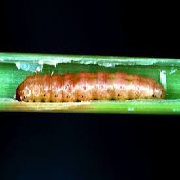

In [ ]:
img = image.load_img('/content/pest/test/stem_borer/jpg_12.jpg',target_size=(img_height,img_width))
img

In [ ]:
test_image=image.img_to_array(img)
test_image=np.expand_dims(test_image, axis = 0)

result =np.argmax(model.predict(test_image), axis=1)
result

1/1 [==============================] - 0s 48ms/step


array([8])

In [ ]:
prediction2 = class_names[result[0]]
prediction2

'stem_borer'

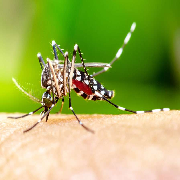

In [ ]:
img = image.load_img('/content/pest/test/mosquito/jpg_10.jpg',target_size=(img_height,img_width))
img

In [ ]:
test_image=image.img_to_array(img)
test_image=np.expand_dims(test_image, axis = 0)

result =np.argmax(model.predict(test_image), axis=1)
result

1/1 [==============================] - 0s 30ms/step


array([6])

In [ ]:
prediction3 = class_names[result[0]]
prediction3

'mosquito'

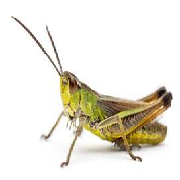

In [ ]:
img = image.load_img('/content/pest/test/grasshopper/jpg_10.jpg',target_size=(img_height,img_width))
img

In [ ]:
test_image=image.img_to_array(img)
test_image=np.expand_dims(test_image, axis = 0)

result =np.argmax(model.predict(test_image), axis=1)
result

1/1 [==============================] - 0s 31ms/step


array([4])

In [ ]:
prediction4 = class_names[result[0]]
prediction4

'grasshopper'

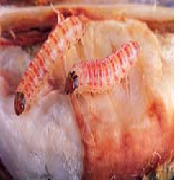

In [ ]:
img = image.load_img('/content/pest/test/bollworm/jpg_10.jpg',target_size=(img_height,img_width))
img

In [ ]:
test_image=image.img_to_array(img)
test_image=np.expand_dims(test_image, axis = 0)

result =np.argmax(model.predict(test_image), axis=1)
result

1/1 [==============================] - 0s 29ms/step


array([3])

In [ ]:
prediction5 = class_names[result[0]]
prediction5

'bollworm'

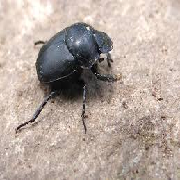

In [ ]:

img = image.load_img('/content/pest/test/beetle/jpg_10.jpg',target_size=(img_height,img_width))
img

In [ ]:
test_image=image.img_to_array(img)
test_image=np.expand_dims(test_image, axis = 0)

result =np.argmax(model.predict(test_image), axis=1)
result

1/1 [==============================] - 0s 33ms/step


array([2])

In [ ]:
prediction6 = class_names[result[0]]
prediction6

'beetle'

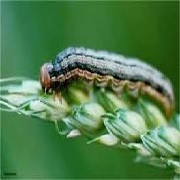

In [ ]:
img = image.load_img('/content/pest/test/armyworm/jpg_10.jpg',target_size=(img_height,img_width))
img

In [ ]:
test_image=image.img_to_array(img)
test_image=np.expand_dims(test_image, axis = 0)

result =np.argmax(model.predict(test_image), axis=1)
result

1/1 [==============================] - 0s 52ms/step


array([1])

In [ ]:
prediction7 = class_names[result[0]]
prediction7

'armyworm'

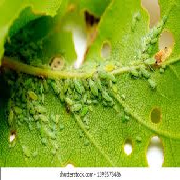

In [ ]:
img = image.load_img('/content/pest/test/aphids/jpg_11 - Copy.jpg',target_size=(img_height,img_width))
img

In [ ]:
test_image=image.img_to_array(img)
test_image=np.expand_dims(test_image, axis = 0)
result =np.argmax(model.predict(test_image), axis=1)
result

1/1 [==============================] - 0s 29ms/step


array([0])

In [ ]:
prediction8 = class_names[result[0]]
prediction8

'aphids'

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory('/content/pest/test',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 450 files belonging to 9 classes.
Using 90 files for validation.


In [ ]:
true_labels = []
predicted_labels = []

In [ ]:
# Iterate through the test dataset to make predictions
for images, labels in test_ds:
    predicted_batch = model.predict(images)
    predicted_labels.extend(np.argmax(predicted_batch, axis=1))
    true_labels.extend(labels.numpy())

1/1 [==============================] - 0s 417ms/step


In [ ]:
# Calculate accuracy
accuracy = metrics.accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

Accuracy: 0.7


In [ ]:
# Generate a classification report
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

      aphids       0.88      0.78      0.82         9
    armyworm       0.82      0.69      0.75        13
      beetle       0.86      0.67      0.75         9
    bollworm       0.60      0.43      0.50         7
 grasshopper       0.62      0.56      0.59         9
       mites       0.60      0.86      0.71         7
    mosquito       0.63      0.92      0.75        13
      sawfly       0.86      0.55      0.67        11
  stem_borer       0.60      0.75      0.67        12

    accuracy                           0.70        90
   macro avg       0.72      0.69      0.69        90
weighted avg       0.72      0.70      0.70        90



In [ ]:
# Compute and display the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[ 7  0  0  1  0  0  1  0  0]
 [ 0  9  1  0  1  1  1  0  0]
 [ 0  0  6  0  2  0  1  0  0]
 [ 0  0  0  3  0  0  0  1  3]
 [ 1  1  0  0  5  2  0  0  0]
 [ 0  1  0  0  0  6  0  0  0]
 [ 0  0  0  0  0  0 12  0  1]
 [ 0  0  0  1  0  1  1  6  2]
 [ 0  0  0  0  0  0  3  0  9]]


In [ ]:
# Save the model's architecture to a JSON file
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)


In [ ]:
# Save the model's weights to an HDF5 file
model.save_weights("model_weights.h5")

In [ ]:
# Assume that you want to store the model files in your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy the model files to your Google Drive
!cp model.json "/content/drive/My Drive/"
!cp model_weights.h5 "/content/drive/My Drive/"

In [ ]:
# Now, let's simulate a new Colab session and load the model

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import model_from_json

In [ ]:
# Load the model's architecture
with open("/content/drive/MyDrive/model.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

In [ ]:
# Load the model's weights
loaded_model.load_weights("/content/drive/My Drive/model_weights.h5")

In [ ]:
# Compile the model
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=9,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dense(num_classes))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper (ModuleWrap  (None, 2048)              0         
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 128)               262272    
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 9)                 1161      
 apper)                                                          
                                                                 
Total params: 23851145 (90.98 MB)
Trainable params: 263433 (1.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________

In [ ]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
epochs=30
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
17/17 [==============================] - 89s 5s/step - loss: 1.6141 - accuracy: 0.4593 - val_loss: 1.0618 - val_accuracy: 0.6556
Epoch 2/30
17/17 [==============================] - 92s 5s/step - loss: 0.4499 - accuracy: 0.8574 - val_loss: 0.8138 - val_accuracy: 0.7111
Epoch 3/30
17/17 [==============================] - 92s 6s/step - loss: 0.1754 - accuracy: 0.9611 - val_loss: 0.6760 - val_accuracy: 0.8111
Epoch 4/30
17/17 [==============================] - 82s 5s/step - loss: 0.0908 - accuracy: 0.9926 - val_loss: 0.5790 - val_accuracy: 0.8444
Epoch 5/30
17/17 [==============================] - 96s 6s/step - loss: 0.0462 - accuracy: 0.9963 - val_loss: 0.5855 - val_accuracy: 0.8444
Epoch 6/30
17/17 [==============================] - 96s 6s/step - loss: 0.0284 - accuracy: 0.9981 - val_loss: 0.5905 - val_accuracy: 0.8444
Epoch 7/30
17/17 [==============================] - 99s 6s/step - loss: 0.0279 - accuracy: 0.9963 - val_loss: 0.6004 - val_accuracy: 0.8444
Epoch 8/30
17/17 [==

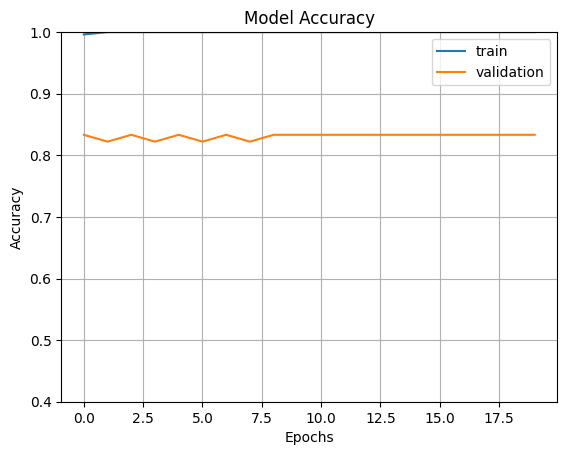

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

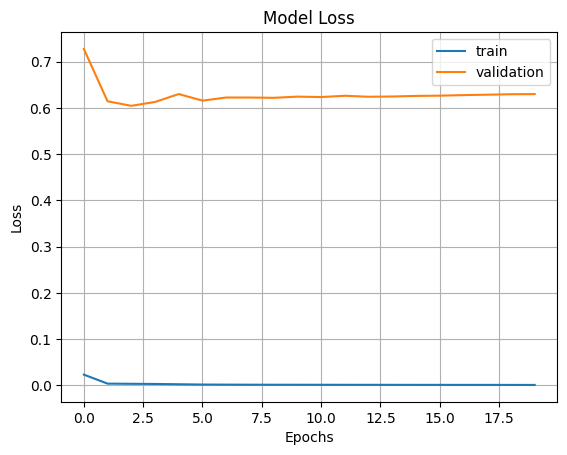

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

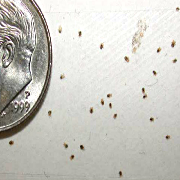

In [ ]:
from tensorflow.keras.preprocessing import image

img1 = image.load_img('/content/pest/test/mites/jpg_14.jpg',target_size=(img_height,img_width))
img1

In [ ]:
test_image=image.img_to_array(img1)
test_image=np.expand_dims(test_image, axis = 0)
result =np.argmax(resnet_model.predict(test_image), axis=1)
result

1/1 [==============================] - 0s 157ms/step


array([5])

In [ ]:
predictions1 = class_names[result[0]]
predictions1

'mites'

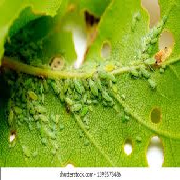

In [ ]:
img2 = image.load_img('/content/pest/test/aphids/jpg_11 - Copy.jpg',target_size=(img_height,img_width))
img2

In [ ]:
test_image=image.img_to_array(img2)
test_image=np.expand_dims(test_image, axis = 0)
result =np.argmax(resnet_model.predict(test_image), axis=1)
result

1/1 [==============================] - 0s 247ms/step


array([0])

In [ ]:
predictions2 = class_names[result[0]]
predictions2

'aphids'

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory('/content/pest/test',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 450 files belonging to 9 classes.
Using 90 files for validation.


In [ ]:
true_labels = []
predicted_labels = []

In [ ]:
# Iterate through the test dataset to make predictions
for images, labels in test_ds:
    predicted_batch = resnet_model.predict(images)
    predicted_labels.extend(np.argmax(predicted_batch, axis=1))
    true_labels.extend(labels.numpy())

1/1 [==============================] - 3s 3s/step


In [ ]:
# Calculate accuracy
accuracy = metrics.accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

Accuracy: 0.8333333333333334


In [ ]:
# Generate a classification report
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

      aphids       0.89      0.89      0.89         9
    armyworm       0.92      0.92      0.92        13
      beetle       0.88      0.78      0.82         9
    bollworm       0.67      0.86      0.75         7
 grasshopper       0.88      0.78      0.82         9
       mites       0.70      1.00      0.82         7
    mosquito       1.00      1.00      1.00        13
      sawfly       0.69      0.82      0.75        11
  stem_borer       0.86      0.50      0.63        12

    accuracy                           0.83        90
   macro avg       0.83      0.84      0.82        90
weighted avg       0.85      0.83      0.83        90



In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import glob

# Define IMAGE_SIZE and other parameters
IMAGE_SIZE = [180, 180]
BATCH_SIZE = 32


# Load the pre-trained VGG16 model
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Freeze the layers of the pre-trained model
for layer in vgg.layers:
    layer.trainable = False

num_classes = len(class_names)

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Scale pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define the custom top layers
x = Flatten()(vgg.output)
prediction = Dense(num_classes, activation='softmax')(x)

# Create the custom model
vgg_model = Model(inputs=vgg.input, outputs=prediction)

# Compile the model
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),  # You can adjust the learning rate as needed
    metrics=['accuracy']
)

# Load and preprocess your dataset using the datagen
train_ds = datagen.flow_from_directory(
    '/content/pest/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_ds = datagen.flow_from_directory(
    '/content/pest/test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 2700 images belonging to 9 classes.
Found 450 images belonging to 9 classes.


In [ ]:
epochs=5
history = vgg_model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=15,
    epochs=epochs
)

Epoch 1/5
15/15 [==============================] - 382s 26s/step - loss: 1.2017 - accuracy: 0.6521 - val_loss: 1.2567 - val_accuracy: 0.6756
Epoch 2/5
15/15 [==============================] - 388s 27s/step - loss: 1.2217 - accuracy: 0.6396 - val_loss: 1.2149 - val_accuracy: 0.6533
Epoch 3/5
15/15 [==============================] - 378s 26s/step - loss: 1.2022 - accuracy: 0.6587 - val_loss: 1.1990 - val_accuracy: 0.6578
Epoch 4/5
15/15 [==============================] - 379s 26s/step - loss: 1.1533 - accuracy: 0.6630 - val_loss: 1.1884 - val_accuracy: 0.6578
Epoch 5/5
15/15 [==============================] - 356s 24s/step - loss: 1.1013 - accuracy: 0.6667 - val_loss: 1.1844 - val_accuracy: 0.6711


In [ ]:
import matplotlib.pyplot as plt

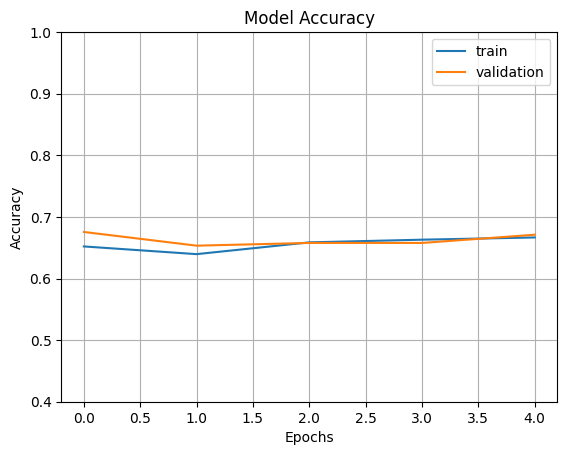

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

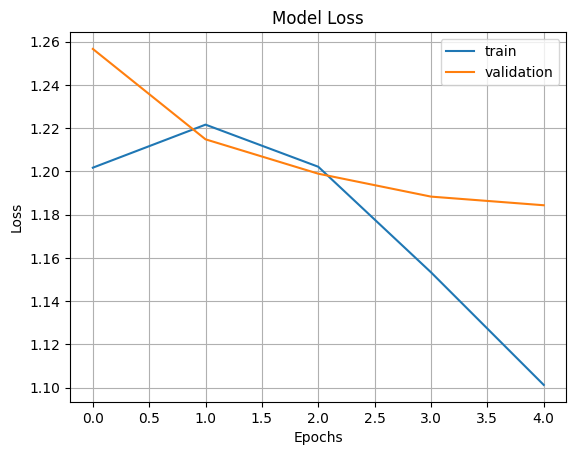

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

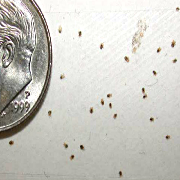

In [ ]:
from tensorflow.keras.preprocessing import image

img3 = image.load_img('/content/pest/test/mites/jpg_14.jpg',target_size=(img_height,img_width))
img3

In [ ]:
test_image=image.img_to_array(img3)
test_image=np.expand_dims(test_image, axis = 0)
result =np.argmax(vgg_model.predict(test_image), axis=1)
result

1/1 [==============================] - 2s 2s/step


array([5])

In [ ]:
predictions2 = class_names[result[0]]
predictions2

'mites'

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory('/content/pest/test',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 450 files belonging to 9 classes.
Using 90 files for validation.


In [ ]:
true_labels = []
predicted_labels = []

In [ ]:
# Iterate through the test dataset to make predictions
for images, labels in test_ds:
    predicted_batch = vgg_model.predict(images)
    predicted_labels.extend(np.argmax(predicted_batch, axis=1))
    true_labels.extend(labels.numpy())

1/1 [==============================] - 9s 9s/step


In [ ]:
# Calculate accuracy
accuracy = metrics.accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

Accuracy: 0.5


In [ ]:
# Generate a classification report
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

      aphids       0.00      0.00      0.00         9
    armyworm       1.00      0.31      0.47        13
      beetle       0.36      0.89      0.52         9
    bollworm       0.75      0.43      0.55         7
 grasshopper       1.00      0.89      0.94         9
       mites       1.00      0.29      0.44         7
    mosquito       1.00      0.85      0.92        13
      sawfly       0.20      0.64      0.30        11
  stem_borer       0.50      0.17      0.25        12

    accuracy                           0.50        90
   macro avg       0.65      0.49      0.49        90
weighted avg       0.65      0.50      0.49        90



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
